In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import random
import json

Set seeds

In [2]:
seed_value = 52
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Prepare Data 


Additionally, visualize the data

In [3]:
#Load in data
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

df = pd.read_csv(data_path)

ts = df["Close"].values

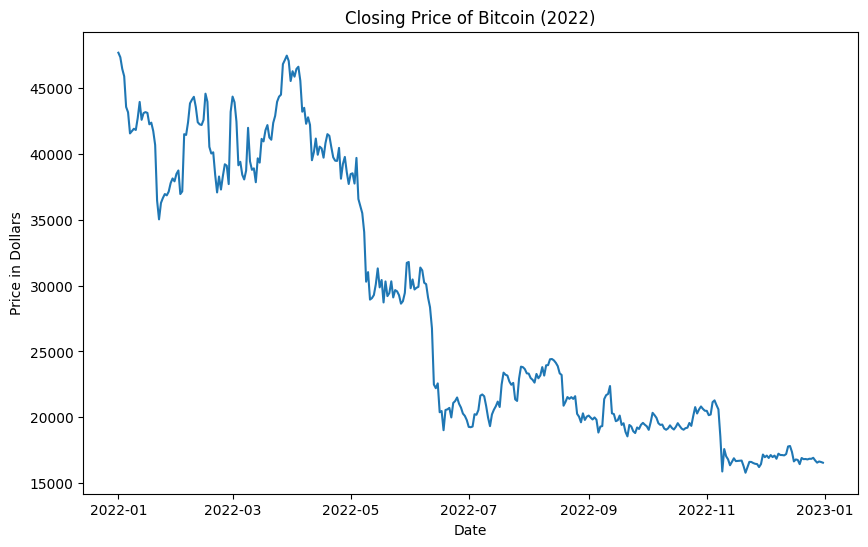

In [4]:
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

plt.figure(figsize=(10, 6))
plt.plot(date_range, ts)
plt.title('Closing Price of Bitcoin (2022)')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.show()

### Train-Validation-Test Split

Check dimensions

In [18]:
print(ts.shape)

ts = ts.reshape(365,1)
print(ts.shape)

(365,)
(365, 1)


In [19]:
# train-test split for time series
train_size = int(len(ts) * 0.60)
train, rest = ts[:train_size], ts[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

219
73
73


### Create tensor dataset

In [20]:
def create_dataset(dataset, lookback):
    """
    Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    return torch.tensor(np.array(X)), torch.tensor((y))

lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_valid, y_valid = create_dataset(validation, lookback=lookback)

Inspect shape of tensors

In [21]:
print(f"X_train, y_train shape {X_train.shape, y_train.shape}")
print(f"X_valid, y_valid shape: {X_valid.shape, y_valid.shape}")
print(f"X_test, y_test shape: {X_test.shape, y_test.shape}")

X_train, y_train shape (torch.Size([207, 12, 1]), torch.Size([207, 1, 1]))
X_valid, y_valid shape: (torch.Size([61, 12, 1]), torch.Size([61, 1, 1]))
X_test, y_test shape: (torch.Size([61, 12, 1]), torch.Size([61, 1, 1]))


## LSTM Class


In [22]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=110, num_layers=1, batch_first=True)
        self.linear = nn.Linear(110, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1:, :])
        return x
    def regularization(self, lambda_):
        reg_term = torch.tensor(0.0)
        for param in self.parameters():
            reg_term += torch.sum(param**2)
        return lambda_ * reg_term

## Training


In [ ]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=32)

#Training configuration
n_epochs = 1000
patience = 25
best_epoch = 0
best_valid_rmse = float('inf')
best_train_rmse = 0
patience_counter = 0

for epoch in range(n_epochs+1):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    #Progress Printer
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
            
            y_pred = model(X_valid)
            valid_rmse = torch.sqrt(loss_fn(y_pred, y_valid))
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, validation RMSE {valid_rmse:.4f}")
    
    if train_rmse < 0.02:
        #Early stopping
        if valid_rmse < best_valid_rmse:
            best_epoch = epoch
            best_train_rmse = train_rmse
            best_valid_rmse = valid_rmse
            patience_counter = 0
        else:
            patience_counter += 1

        # Stop training if patience has been exceeded
        if patience_counter >= patience:
            print(f"Early stopping at Epoch {epoch}: The train RMSE {train_rmse:.4f}, best validation RMSE {best_valid_rmse:.4f}")
            break

## Plotting Results of LSTM



In [ ]:
with torch.no_grad():
    ##Shift train predictions for plotting
    train_plot = np.ones_like(diff) * np.nan
    y_hat_train = model(X_train)
    rmse_train = torch.sqrt(loss_fn(y_hat_train, y_train))
    y_hat_train = y_hat_train.reshape(train_size-lookback,1)
    train_plot[lookback:train_size] = y_hat_train


    valid_plot = np.ones_like(diff) * np.nan
    y_hat_valid = model(X_valid)
    rmse_valid = torch.sqrt(loss_fn(y_hat_valid, y_valid))
    y_hat_valid = y_hat_valid.reshape(validation_size-lookback,1)
    valid_plot[train_size+lookback:train_size+len(y_valid)+lookback] = y_hat_valid


    test_plot = np.ones_like(diff) * np.nan
    y_hat_test = model(X_test)
    rmse_test = torch.sqrt(loss_fn(y_hat_test, y_test))
    y_hat_test = y_hat_test.reshape(len(test)-lookback,1)
    test_plot[train_size+lookback+len(y_valid)+lookback:] = y_hat_test

print(f"train RMSE {rmse_train:.4f}, validation RMSE {rmse_valid:.4f}, test RMSE {rmse_test:.4f}")


# plot
plt.plot(diff, label='Bitcoin series')
plt.plot(train_plot, c='orange', label="Training Y-Hats")
plt.plot(valid_plot, c='green', label='Validation Y-Hats')
plt.plot(test_plot, c='r', label='Validation Y-Hats')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("3-forecasts.png")
plt.show()

In [ ]:
plt.plot(y_hat_train, c='orange', label="Predicted Values")
plt.plot(y_train.squeeze(), label="Actual Train")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Returns of Bitcoin')
plt.legend()
plt.savefig("train.png")
plt.show()


plt.plot(y_hat_valid, c='green', label="Predicted Values")
plt.plot(y_valid.squeeze(), label="Actual Y")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Returns of Bitcoin ')
plt.legend()
plt.savefig("valid.png")
plt.show()

plt.plot(y_hat_test, c='red', label="Predicted Values")
plt.plot(y_test.squeeze(), label="Actual Y")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Returns of Bitcoin')
plt.legend()
plt.savefig("test.png")
plt.show()